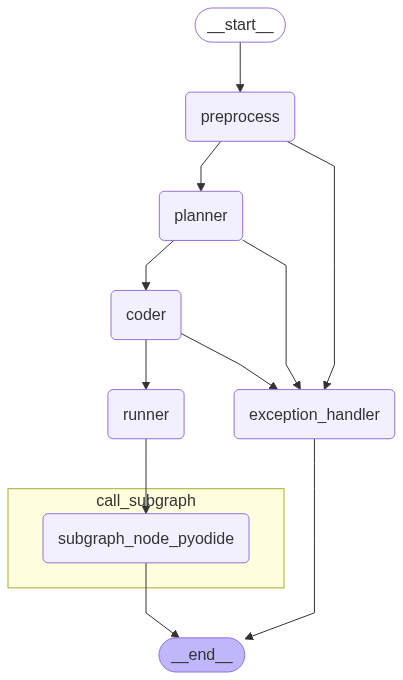

In [5]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage

from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def preprocess(state: MessagesState) -> MessagesState:
    """Preprocess the input data."""
    return {"messages": AIMessage("Preprocessing complete.")}

def planner(state: MessagesState) -> MessagesState:
    """Plan the next steps based on preprocessed data."""
    return {"messages": [HumanMessage("Create plan..."), AIMessage("Plan created.")]}

def coder(state: MessagesState) -> MessagesState:
    """Generate code based on the plan."""
    return {"messages": [HumanMessage("Meta Prompt..."), AIMessage("Program generated...")]}

def runner(state: MessagesState) -> MessagesState:
    """Run the generated code."""
    return {"messages": [AIMessage("Execution complete.")]}

def exception_handler(state: MessagesState) -> MessagesState:
    """Handle exceptions."""
    return {"messages": [AIMessage("An error occurred. Please try again.")]}


class SubgraphState(TypedDict):
    bar: str

# Subgraph

def subgraph_node_pyodide(state: SubgraphState):
    return {"bar": "hi! " + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node("subgraph_node_pyodide", subgraph_node_pyodide)
subgraph_builder.add_edge(START, "subgraph_node_pyodide")
subgraph = subgraph_builder.compile()


def call_subgraph(state: MessagesState):
    subgraph_output = subgraph.invoke({"bar": state["foo"]})  
    return {"foo": subgraph_output["bar"]}  

# Define nodes: these do the work
builder = StateGraph(MessagesState)
builder.add_node("preprocess", preprocess)
builder.add_node("planner", planner)
builder.add_node("coder", coder)
builder.add_node("runner", runner)
builder.add_node("call_subgraph", call_subgraph)




builder.add_node("exception_handler", exception_handler)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "preprocess")
builder.add_edge("preprocess", "planner")
builder.add_edge("planner", "coder")
builder.add_edge("preprocess", "exception_handler")
builder.add_edge("planner", "exception_handler")
builder.add_edge("coder", "exception_handler")
builder.add_edge("preprocess", "exception_handler")
builder.add_edge("coder", "runner")
builder.add_edge("runner", "call_subgraph")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))